In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [11]:
from google.colab import files
uploaded = files.upload()

Saving Cleaned.xlsx to Cleaned (1).xlsx


In [12]:
df = pd.read_excel('Cleaned.xlsx', index_col=0)
df.head()

,Codes,Interview Presence,Concrete/Conceptual,I_1,I_2,I_3,I_4,I_5,I_6,I_7,...,I_18,I_19,I_20,I_21,I_22,I_23,I_24,I_25,I_26,I_27
ID,,,,,,,,,,,,,,,,,,,,,
1.0,Allow benchmarking practices,4,Conceptual,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
NaN,confidence in practices,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
NaN,food safety and perfomance,4,NaN,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4.0,DS to enable risk mitigation,12,Conceptual,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,1,1
NaN,allow for food safety improvement,7,NaN,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [13]:
def track_child_code_trajectory(df):
    child_trajectories = {}
    parent_mapping = {}  # maps child code description to parent code description
    current_parent_description = None

    # Iterate using iloc to access rows by integer position and index values
    for i in range(len(df)):
        index_value = df.index[i]
        row = df.iloc[i]

        code_description = row['Codes'] # description for the current row

        # If index_value is not NaN, it's a parent row
        if pd.notna(index_value):
            current_parent_description = code_description # stores the parent's actual code description
            continue #skips to the next row, as parents don't have trajectories in meaning analysis

        # If index_value is NaN, it's a child row (head data should reflect this)
        child_code_description = code_description # The child code's actual name

        # Map this child to its current parent
        parent_mapping[child_code_description] = current_parent_description

        # Get the row data for interviews only, dropping the 'Code' column
        interview_data = row.drop('Codes')

        interviews_present = []
        for col in interview_data.index:
            if str(col).startswith('I_') and interview_data[col] == 1:
                interview_num = int(str(col).split('_')[1])
                interviews_present.append(interview_num)

        if interviews_present:
            child_trajectories[child_code_description] = sorted(interviews_present)
        else:
            child_trajectories[child_code_description] = []

    return child_trajectories, parent_mapping


def create_detailed_output(child_trajectories, parent_mapping, milestones):
    """
    Placeholder for a function to create detailed text output.
    Returns a simple string for now to resolve NameError.
    """
    output_lines = []
    output_lines.append("Detailed Trajectory Analysis:")
    output_lines.append("----------------------------")

    # Example: List parent codes and their children
    parents_with_children = {}
    for child, parent in parent_mapping.items():
        if parent not in parents_with_children:
            parents_with_children[parent] = []
        parents_with_children[parent].append(child)

    for parent, children in parents_with_children.items():
        output_lines.append(f"\nParent Code: {parent}")
        for child in children:
            trajectory = child_trajectories.get(child, [])
            output_lines.append(f"  - Child Code: {child}, Trajectory: {trajectory}")

    return "\n".join(output_lines)

# Run the analysis
child_trajectories, parent_mapping = track_child_code_trajectory(df)

print(f"Child trajectories found: {len(child_trajectories)}")
print(f"Parent mappings found: {len(parent_mapping)}")

Child trajectories found: 120
Parent mappings found: 120


Including all parent codes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

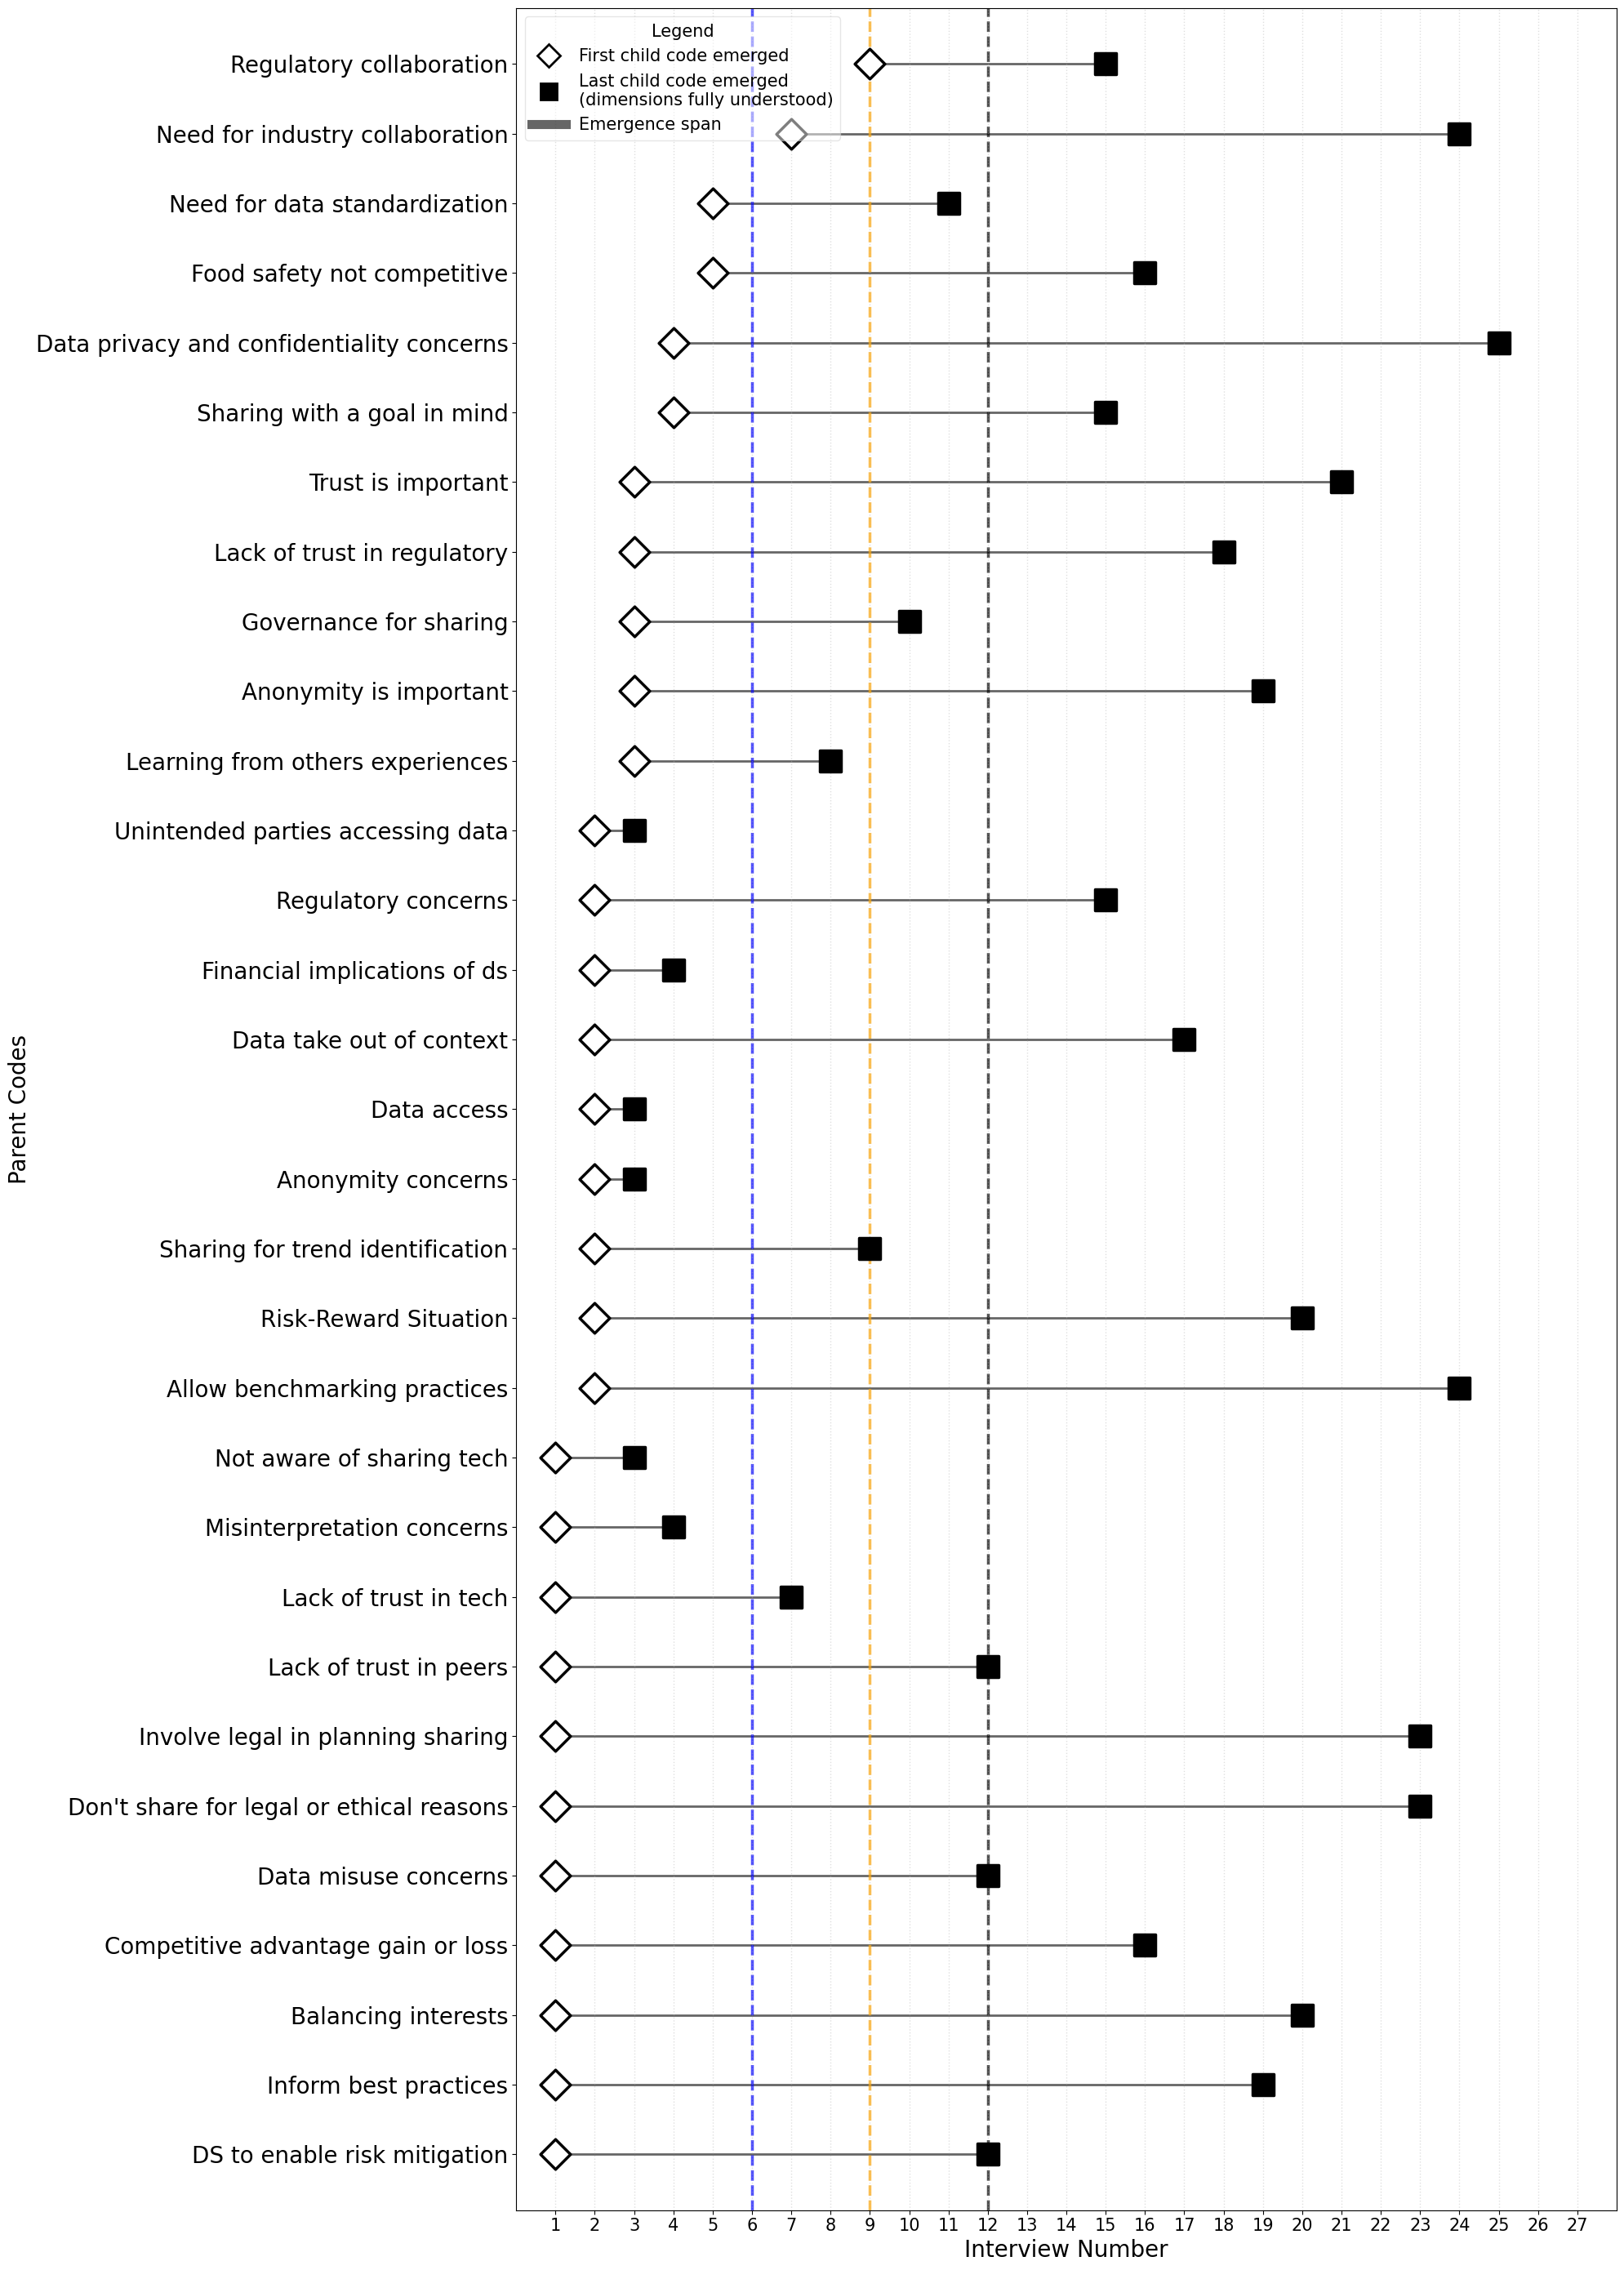


✓ All figures created!


In [14]:
def create_parent_dimension_span_figure(child_trajectories, parent_mapping, coded_matrix,
                                       id_column='ID', parent_ids=None,
                                       max_interview=27, milestones=[6, 9, 12]):

    # Create mapping from parent ID to parent code name
    id_to_parent = {}
    for index_value, row in coded_matrix.iterrows(): # Iterate over index and rows
        if pd.notna(index_value): # If the index value (ID) is not NaN, it's a parent row
            parent_id = int(index_value) # The parent ID is the index value itself
            parent_code_name = row['Codes'] # The parent code name is in the 'Codes' column
            id_to_parent[parent_id] = parent_code_name

    # Filter parents based on selected IDs
    if parent_ids is not None:
        selected_parents = [id_to_parent[pid] for pid in parent_ids if pid in id_to_parent]
        print(f"Selected parents: {selected_parents}")
    else:
        selected_parents = None
        print("Including all parent codes")

    # Calculate first and last child code appearance for each parent
    parent_spans = {}

    for child_code, parent_code in parent_mapping.items():
        # Skip if this parent is not in the selected list
        if selected_parents is not None and parent_code not in selected_parents:
            continue

        if parent_code not in parent_spans:
            parent_spans[parent_code] = {
                'first_child': float('inf'),
                'last_child': 0,
                'child_count': 0,
                'first_appearances': []
            }

        trajectory = child_trajectories.get(child_code, [])
        if trajectory:
            first_appearance = trajectory[0]
            parent_spans[parent_code]['first_appearances'].append(first_appearance)
            parent_spans[parent_code]['child_count'] += 1
            parent_spans[parent_code]['first_child'] = min(
                parent_spans[parent_code]['first_child'],
                first_appearance
            )
            parent_spans[parent_code]['last_child'] = max(
                parent_spans[parent_code]['last_child'],
                first_appearance
            )

    if not parent_spans:
        print("No parent codes found with the selected IDs!")
        return None, None, None

    # Sort parents by when their first child appeared
    parent_order = sorted(parent_spans.keys(),
                         key=lambda p: parent_spans[p]['first_child'])

    # Create figure
    fig, ax = plt.subplots(figsize=(20, max(8, len(parent_order) * 0.9))) # Reduced figure width from 30 to 25

    # Color settings
    colors = plt.cm.Set1(np.linspace(0, 1, len(parent_order)))
    parent_colors = dict(zip(parent_order, colors))

    # Plot each parent's span
    for idx, parent in enumerate(parent_order):
        y_pos = idx
        data = parent_spans[parent]

        first = data['first_child']
        last = data['last_child']
        child_count = data['child_count']
        span_length = last - first

        # Span setting
        ax.plot([first, last], [y_pos, y_pos],
               color='black', linewidth=2,
               alpha=0.6, zorder=1, solid_capstyle='round')

        # First child code marker setting
        ax.scatter(first, y_pos, s=350, marker='D',
                  c=['white'],
                  edgecolors='black', linewidths=2.5, zorder=4,
                  label='First child')

        # Last child code marker setting
        ax.scatter(last, y_pos, s=350, marker='s',
                  c=['black'],
                  edgecolors='black', linewidths=2.5, zorder=4,
                  label='Last child')

    # Adding vertical lines for milestones
    milestone_colors = ['blue', 'orange', 'black']
    for milestone, color in zip(milestones, milestone_colors):
        ax.axvline(x=milestone, color=color, linestyle='--',
                  linewidth=2.5, alpha=0.7, zorder=1,
                  label=f'Interview {milestone}')

    yticklabels = []
    for parent in parent_order:
        # Original line: yticklabels.append(f"{parent}\n(n={data['child_count']}, span={span} int.)")
        yticklabels.append(f"{parent}") # Only the parent code name

    ax.set_yticks(range(len(parent_order)))
    ax.set_yticklabels(yticklabels, fontsize=20, fontweight='normal') # Unbold y-axis tick labels

    # Formatting
    ax.set_xlabel('Interview Number', fontsize=20, fontweight='normal') # Bold x-axis label
    ax.set_ylabel('Parent Codes',
                 fontsize=20, fontweight='normal') # Bold y-axis label

    # X-axis
    ax.set_xlim(0, max_interview + 1)
    ax.set_xticks(range(1, max_interview + 1))
    ax.tick_params(axis='x', labelsize=15) # Increase x-axis tick label font size
    ax.grid(True, axis='x', alpha=0.4, linestyle=':', linewidth=1)

    # Y-axis limits
    ax.set_ylim(-0.8, len(parent_order) - 0.2)

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='white',
                  markersize=14, markeredgecolor='black', markeredgewidth=2,
                  label='First child code emerged'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black',
                  markersize=14, markeredgecolor='black', markeredgewidth=2,
                  label='Last child code emerged\n(dimensions fully understood)'),

        plt.Line2D([0], [0], color='black', linewidth=8, alpha=0.6,
                  label='Emergence span')
    ]


    # Legend setting
    ax.legend(handles=legend_elements, loc='upper left',
             fontsize=15, title='Legend', framealpha=0.50, title_fontsize=15)

    plt.tight_layout()

    # Save with specific filename if parent_ids provided
    if parent_ids:
        filename = f'parent_dimension_span_ids_{' '.join(map(str, parent_ids))}.jpeg'
    else:
        filename = 'parent_dimension_span_all.jpeg'

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    files.download(filename)
    plt.show()

    return fig, ax, parent_spans

# Plotting
fig, ax, parent_spans = create_parent_dimension_span_figure(
    child_trajectories,
    parent_mapping,
    df,
    id_column='ID',
    parent_ids=None,  # None = include all
    max_interview=27,
    milestones=[6, 9, 12]
)

print("\n✓ All figures created!")